Author: Carlos Roberto

Date: 08/20/20

Obj: Reconstruir o modelo gerado anterioemente e usar o Emcee para determinar o ML

In [1]:
import autolens as al
import autolens.plot as aplt
from pyprojroot import here
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


In [2]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#MGE parameters
#Reading data
Surf_mge, sigma, qObs = np.loadtxt('SphericalNFW MGE.txt', unpack=True)

#Converting and computing some quantities
Surf_mge = Surf_mge*(u.solMass/u.pc**2)                        #Surface Density in M_sun/pc²
sigma = sigma*u.arcsec                                         #Sigma in arcsec
sigma_pc = (sigma*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
Mass_mge = 2*np.pi*Surf_mge*(sigma_pc**2)*qObs                 #Total mass per gaussian component in M_sun




#Defining inputs for the integral below
i = np.deg2rad(90)*u.rad                                       #Inclination angle in rad
M0 = Mass_mge                                                  #Mass per gaussian component in M_sun
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)                 #Deprojected axial ratio
sigma0 = (sigma).to(u.rad)                                     #Sigma per gaussian in rad
M0.sum()

<Quantity 1.76749207e+12 solMass>

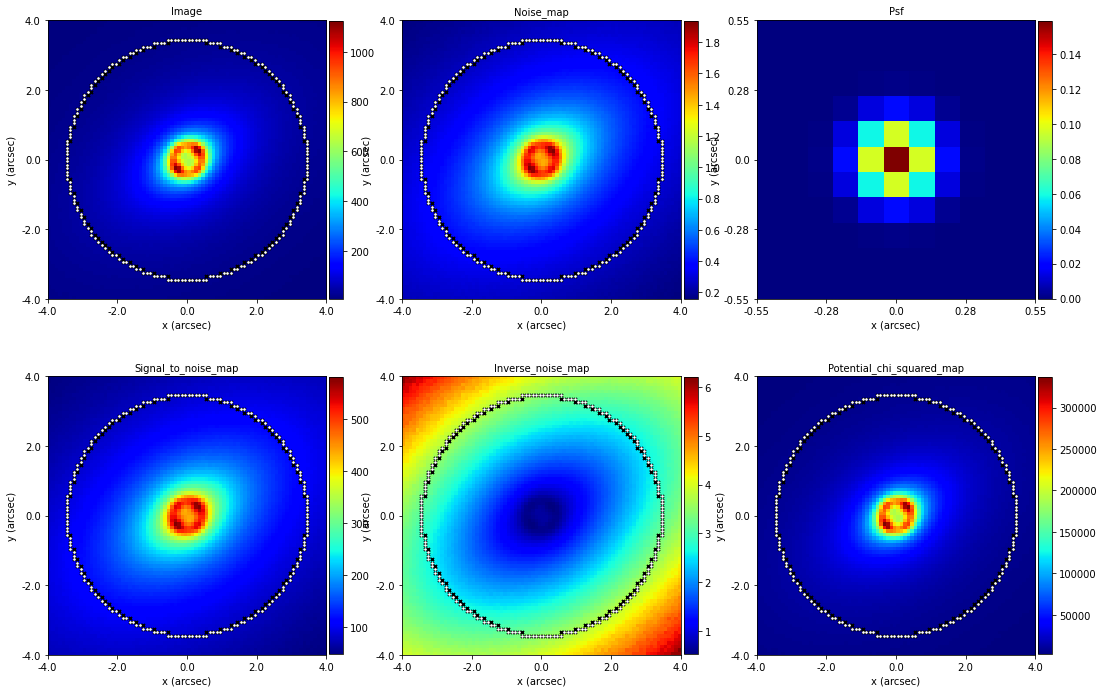

In [3]:
#Reading simulated data

dataset_type = "Emcee Model"
dataset_name = "Data"
dataset_path = f"{workspace_path}/howtolens/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/ImageNFW.fits",
    noise_map_path=f"{dataset_path}/NoiseNFW.fits",
    psf_path=f"{dataset_path}/PSFNFW.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1,radius=3.5 ,centre=(0, 0)
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True)
)

__Defining the correct MGE mass model for the lens galaxy and performing the ray tracing__

In [14]:
#Iniciando o modelo MGE para a lente
time = clock()
ml = 0.93

mass_profile = al.mp.MGE(centre=(0.0, 0.0))                          #Definindo o modelo de massa
mass_profile.MGE_comps(M=ml*M0.value, sigma=sigma0.value,
                       q=q0.value, z_l=z_lens, z_s=z_source)        #Defindo os dados de entrada
mass_profile.MGE_Grid_parameters(masked_imaging.grid)               #Criando a grid de parâmetros para o cálculo
                                                                         #em paralelo
#Criando o modelo da lente
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
    )
print("Tempo para inicializar o modelo de lente MGE:", (clock() - time))
                         

time = clock()
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
print("Tempo para ray tracing:", (clock()-time))

time = clock()
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]
print("Tempo para obter o source plane:", (clock()-time))

Tempo para inicializar o modelo de lente MGE: 0.10619691400006559
Tempo para ray tracing: 0.00015341500056820223
Em série
Tempo para obter o source plane: 79.4337648159999


__Rectangular Inversion__

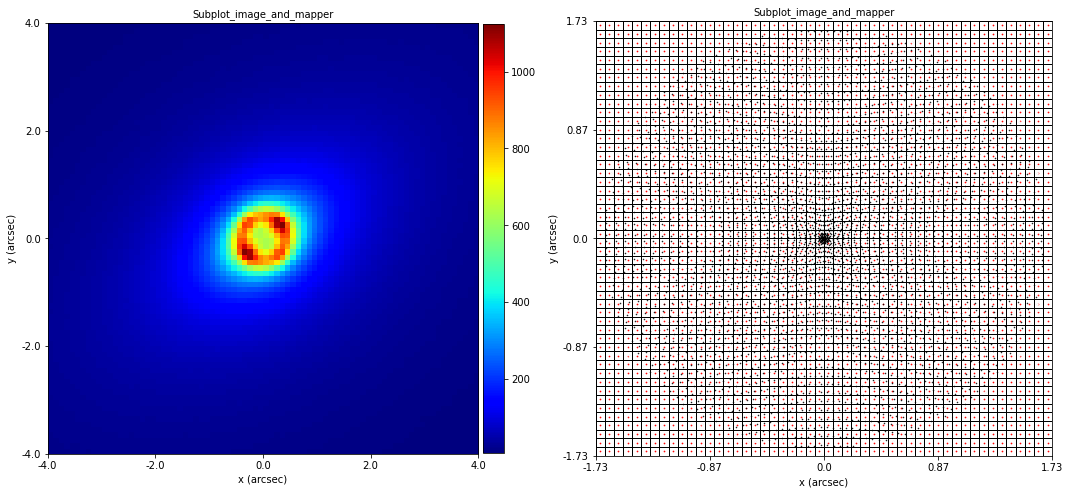

0.465880986997945


In [5]:
time = clock()

rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=False, inversion_grid=True),
)

print(clock() - time)

In [6]:
time = clock()

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=2.5),
)

print(clock() - time)

0.5437251809998997


In [7]:
#Defining some output configs

sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Emcee Model/Output/',
                                          filename='Rectangular Inversion Plots',
                                          format='png'),        
                              )

plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Emcee Model/Output/',
                                          format='png'),         
                          )

include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )


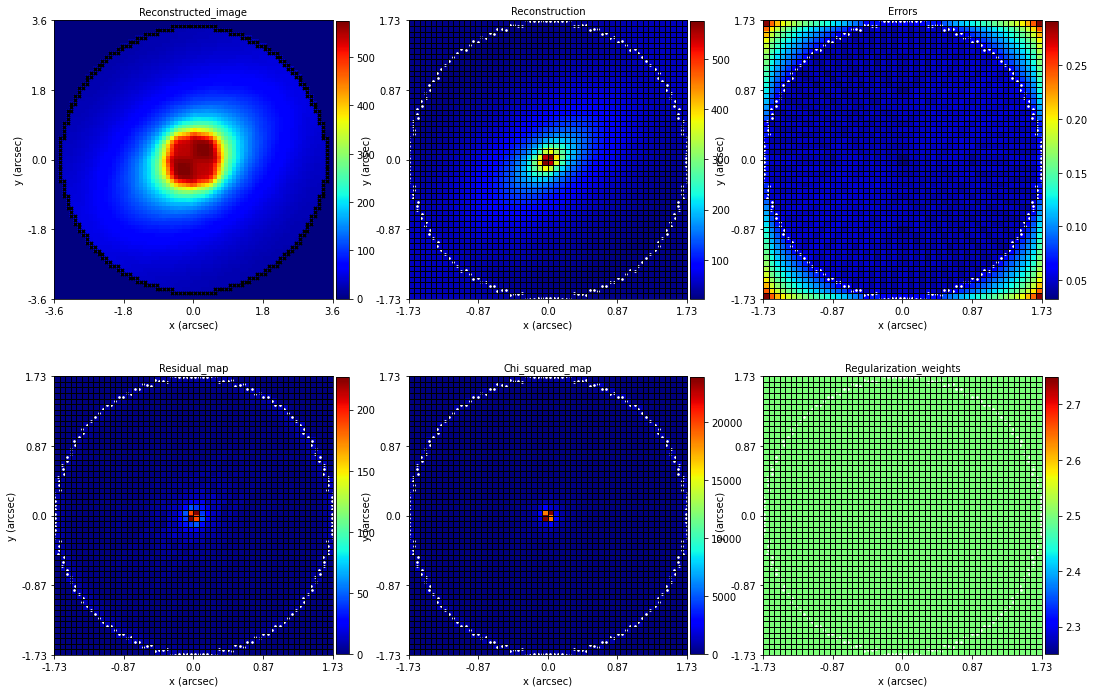

In [8]:
#Ploting Results
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                 sub_plotter=sub_plotter
                                )
 
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                )

In [9]:
inversion.chi_squared_map.sum()

324436.00730264763

__Defining the incorrect MGE mass model for the lens galaxy and performing the ray tracing__

In [10]:


#Iniciando o modelo MGE para a lente
time = clock()
ml = 0.63

mass_profile = al.mp.MGE(centre=(0.0, 0.0))                          #Definindo o modelo de massa
mass_profile.MGE_comps(M=ml*M0.value, sigma=sigma0.value,
                       q=q0.value, z_l=z_lens, z_s=z_source)        #Defindo os dados de entrada
mass_profile.MGE_Grid_parameters(masked_imaging.grid)               #Criando a grid de parâmetros para o cálculo
                                                                         #em paralelo
#Criando o modelo da lente
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
    )
print("Tempo para inicializar o modelo de lente MGE:", (clock() - time))
                         

time = clock()
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
print("Tempo para ray tracing:", (clock()-time))

time = clock()
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]
print("Tempo para obter o source plane:", (clock()-time))

Grid de parâmetros inicializada com sucesso!
Tempo para inicializar o modelo de lente MGE: 0.11010707300010836
Tempo para ray tracing: 0.00028206400020280853
Tamanho do grid 3852
Os grids são Iguais!
Tempo para obter o source plane: 23.90174934499737


__Rectangular Inversion__

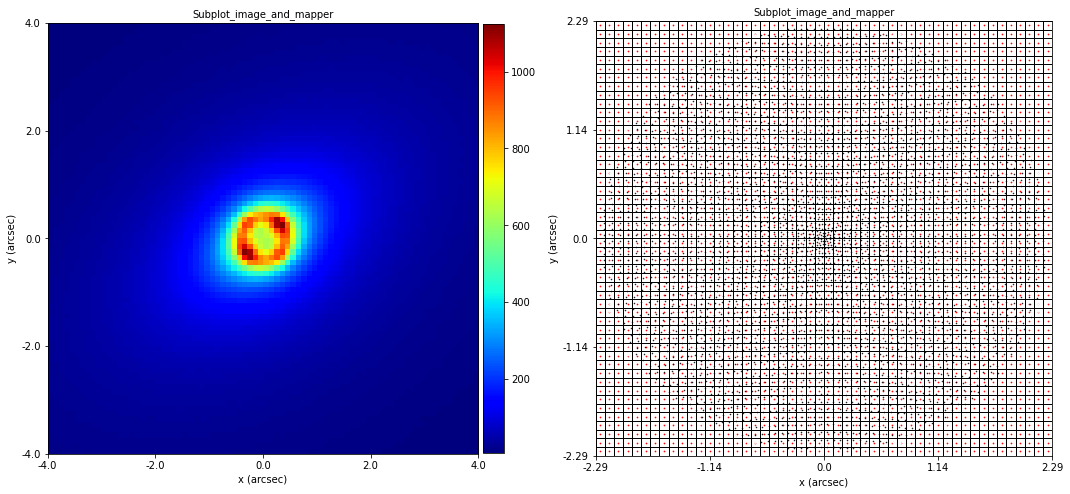

0.6301634920018842


In [11]:
time = clock()

rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=False, inversion_grid=True),
)

print(clock() - time)

In [12]:
time = clock()

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=2.5),
)

print(clock() - time)

0.5034603870008141


In [13]:
#Defining some output configs

sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Emcee Model/Output/',
                                          filename='Rectangular Inversion Plots Incorrect',
                                          format='png'),        
                              )

plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Emcee Model/Output/Incorrect',
                                          format='png'),         
                          )

include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )


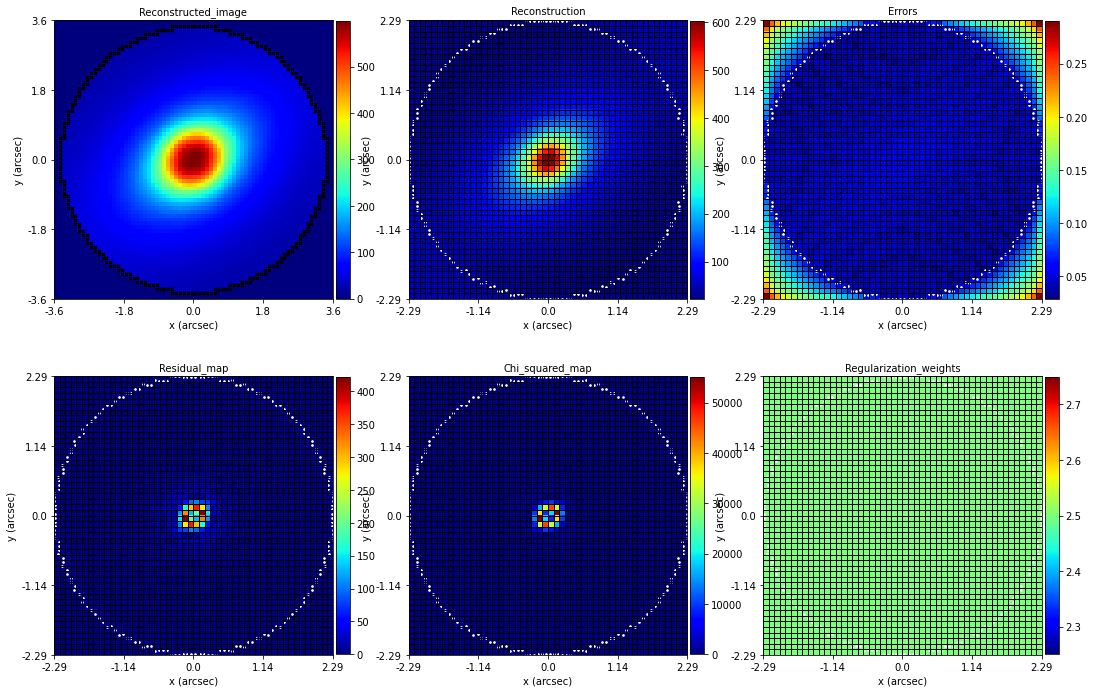

In [14]:
#Ploting Results
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                 sub_plotter=sub_plotter
                                )
 
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                )

In [15]:
inversion.chi_squared_map.sum()

848930.4230907271

Emcee
----------

In [4]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

from time import perf_counter as clock
from multiprocessing import Pool
import time
import os

os.environ["OMP_NUM_THREADS"] = "1"


%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [5]:
ml = 0.63

mass_profile = al.mp.MGE(centre=(0.0, 0.0))                          #Definindo o modelo de massa
mass_profile.MGE_comps(M=ml*M0.value, sigma=sigma0.value,
                       q=q0.value, z_l=z_lens, z_s=z_source)        #Defindo os dados de entrada
mass_profile.MGE_Grid_parameters(masked_imaging.grid)               #Criando a grid de parâmetros para o cálculo
                                                                         #em paralelo
#Criando o modelo da lente
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
    )

M0

<Quantity [9.82065047e-09, 5.28693608e-08, 2.82155381e-07, 1.48414851e-06,
           7.69826047e-06, 3.94132430e-05, 1.99405547e-04, 9.98294055e-04,
           4.95247149e-03, 2.43811879e-02, 1.19281080e-01, 5.80713489e-01,
           2.81694015e+00, 1.36310134e+01, 6.58682212e+01, 3.18149606e+02,
           1.53725791e+03, 7.43536592e+03, 3.60152660e+04, 1.74726664e+05,
           8.48797145e+05, 4.12525923e+06, 2.00228511e+07, 9.67298846e+07,
           4.62222981e+08, 2.16057959e+09, 9.72705676e+09, 4.25019164e+10,
           2.03227025e+11, 1.50929133e+12] solMass>

In [6]:
mass_profile

MGE
centre: (0.0, 0.0)
processes: 1
method: quadva
M: [6.18700979e-09 3.33076973e-08 1.77757890e-07 9.35013559e-07
 4.84990410e-06 2.48303431e-05 1.25625495e-04 6.28925254e-04
 3.12005704e-03 1.53601484e-02 7.51470801e-02 3.65849498e-01
 1.77467230e+00 8.58753843e+00 4.14969793e+01 2.00434252e+02
 9.68472485e+02 4.68428053e+03 2.26896176e+04 1.10077798e+05
 5.34742201e+05 2.59891331e+06 1.26143962e+07 6.09398273e+07
 2.91200478e+08 1.36116514e+09 6.12804576e+09 2.67762073e+10
 1.28033026e+11 9.50853535e+11]
sigma: [5.23908572e-15 1.22755115e-14 2.84855672e-14 6.56158956e-14
 1.50070730e-13 3.40915793e-13 7.69632507e-13 1.72770676e-12
 3.85921677e-12 8.58374743e-12 1.90243603e-11 4.20434594e-11
 9.27100476e-11 2.04108693e-10 4.48897714e-10 9.86745648e-10
 2.16884842e-09 4.76849889e-09 1.04902481e-08 2.30946185e-08
 5.08807110e-08 1.12151900e-07 2.47177165e-07 5.44052095e-07
 1.19329567e-06 2.59805010e-06 5.58309496e-06 1.18374726e-05
 2.57768841e-05 6.99768432e-05]
q: [1. 1. 1. 1. 1. 1.

In [7]:
def log_prior(theta):
    ml = theta
    if 0 < ml < 1:
        pass
    else:
        return -np.inf
    
    return 0.0

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


def log_likelihood(theta):
    ml = theta
    new_M0 = M0*ml
    
    mass_profile.MGE_Updt_parameters(new_M0.value, sigma0.value, q0.value)
    
    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
    source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]
    
    rectangular = al.pix.Rectangular(shape=(50, 50))
    mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)
    
    inversion = al.Inversion(
        masked_dataset=masked_imaging,
        mapper=mapper,
        regularization=al.reg.Constant(coefficient=2.5),
    )
    chi2T = inversion.chi_squared_map.sum()   
    return -0.5 * chi2T

In [8]:
mass_profile = al.mp.MGE(centre=(0.0, 0.0))                          #Definindo o modelo de massa
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value,
                       q=q0.value, z_l=z_lens, z_s=z_source)        #Defindo os dados de entrada
mass_profile.MGE_Grid_parameters(masked_imaging.grid)               #Criando a grid de parâmetros para o cálculo
                                                                         #em paralelo
#Criando o modelo da lente
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
    )

In [26]:
pos = np.random.rand(20,1)
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "Pyautolens Mass-to-Light Serial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


quadva
-------

In [9]:
mass_profile = al.mp.MGE(centre=(0.0, 0.0))                          #Definindo o modelo de massa
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value,
                       q=q0.value, z_l=z_lens, z_s=z_source)        #Defindo os dados de entrada
mass_profile.MGE_Grid_parameters(masked_imaging.grid)               #Criando a grid de parâmetros para o cálculo
                                                                         #em paralelo
#Criando o modelo da lente
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
    )

In [10]:
pos = np.random.rand(20,1)
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "Pyautolens Mass-to-Light quadva.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


In [11]:
with Pool(processes=5) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool, backend=backend)
    start = time.time()
    sampler.run_mcmc(pos, 10, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds during  “burn-in” steps ".format(multi_time))
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadva

Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva


  0%|          | 0/10 [00:00<?, ?it/s]

Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva




Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadva
Integração usando quadvaIntegração usando quadva



Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva


 10%|█         | 1/10 [01:02<09:24, 62.68s/it]

Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva



Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadva
Integração usando quadvaIntegração usando quadva

Integração usando quadva

Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva


 20%|██        | 2/10 [02:05<08:22, 62.83s/it]

Integração usando quadvaIntegração usando quadvaIntegração usando quadva

Integração usando quadva

Integração usando quadva
Integração usando quadvaIntegração usando quadva

Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva




Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva


 30%|███       | 3/10 [03:08<07:19, 62.76s/it]

Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva



Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadva
Integração usando quadva


Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadva

Integração usando quadva


 40%|████      | 4/10 [04:08<06:11, 61.93s/it]

Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva



Integração usando quadva
Integração usando quadvaIntegração usando quadva

Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva

Integração usando quadva


Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva


 50%|█████     | 5/10 [05:15<05:17, 63.56s/it]

Integração usando quadvaIntegração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadva



Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva


Integração usando quadva

Integração usando quadva
Integração usando quadva
Integração usando quadva


 60%|██████    | 6/10 [06:20<04:15, 63.78s/it]

Integração usando quadva
Integração usando quadvaIntegração usando quadva
Integração usando quadva
Integração usando quadva

Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva




Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadva



 70%|███████   | 7/10 [07:29<03:16, 65.38s/it]

Integração usando quadvaIntegração usando quadvaIntegração usando quadva


Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva




Integração usando quadva


 80%|████████  | 8/10 [08:29<02:07, 63.76s/it]

Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva



Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva




Integração usando quadva
Integração usando quadva
Integração usando quadva


 90%|█████████ | 9/10 [09:25<01:01, 61.52s/it]

Integração usando quadvaIntegração usando quadvaIntegração usando quadva


Integração usando quadvaIntegração usando quadva

Integração usando quadvaIntegração usando quadva

Integração usando quadva
Integração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadvaIntegração usando quadva




Integração usando quadvaIntegração usando quadvaIntegração usando quadva


Integração usando quadva
Integração usando quadva


100%|██████████| 10/10 [10:31<00:00, 63.11s/it]

Multiprocessing took 699.0 seconds during  “burn-in” steps 
Mean acceptance fraction: 0.395


Five Processes
--------

In [10]:
with Pool(processes=5) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool, backend=backend)
    start = time.time()
    sampler.run_mcmc(pos, 10, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds during  “burn-in” steps ".format(multi_time))
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

100%|██████████| 10/10 [35:24<00:00, 212.41s/it]

Multiprocessing took 2366.7 seconds during  “burn-in” steps 
Mean acceptance fraction: 0.312


Six Processes
--------

In [15]:
with Pool(processes=6) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool, backend=backend)
    start = time.time()
    sampler.run_mcmc(pos, 10, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds during  “burn-in” steps ".format(multi_time))
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

100%|██████████| 10/10 [35:31<00:00, 213.15s/it]

Multiprocessing took 2357.7 seconds during  “burn-in” steps 
Mean acceptance fraction: 0.300


Serie Multiprocessing Six cores
--------------

In [16]:
mass_profile = al.mp.MGE(centre=(0.0, 0.0), processes=6)                          #Definindo o modelo de massa
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value,
                       q=q0.value, z_l=z_lens, z_s=z_source)        #Defindo os dados de entrada
mass_profile.MGE_Grid_parameters(masked_imaging.grid)               #Criando a grid de parâmetros para o cálculo
                                                                         #em paralelo
#Criando o modelo da lente
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
    )

In [19]:
pos = np.random.rand(20,1)
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "Pyautolens Mass-to-Light Serial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [20]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, backend=backend)
start = time.time()
sampler.run_mcmc(pos, 10, progress=True)
end = time.time()
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


  0%|          | 0/10 [00:00<?, ?it/s]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 10%|█         | 1/10 [09:20<1:24:08, 560.94s/it]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 20%|██        | 2/10 [17:15<1:11:20, 535.02s/it]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 30%|███       | 3/10 [24:38<59:11, 507.35s/it]  

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 40%|████      | 4/10 [33:44<51:54, 519.13s/it]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 50%|█████     | 5/10 [41:35<42:02, 504.50s/it]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 60%|██████    | 6/10 [49:23<32:55, 493.76s/it]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 70%|███████   | 7/10 [58:06<25:07, 502.51s/it]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 80%|████████  | 8/10 [1:06:14<16:35, 497.94s/it]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


 90%|█████████ | 9/10 [1:14:49<08:23, 503.20s/it]

Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6
Paralelo. Número de núcleos é: 6


100%|██████████| 10/10 [1:25:18<00:00, 511.88s/it]

Multiprocessing took 5680.6 seconds


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool, backend=backend)
    start = time.time()
    sampler.run_mcmc(pos, 10, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))


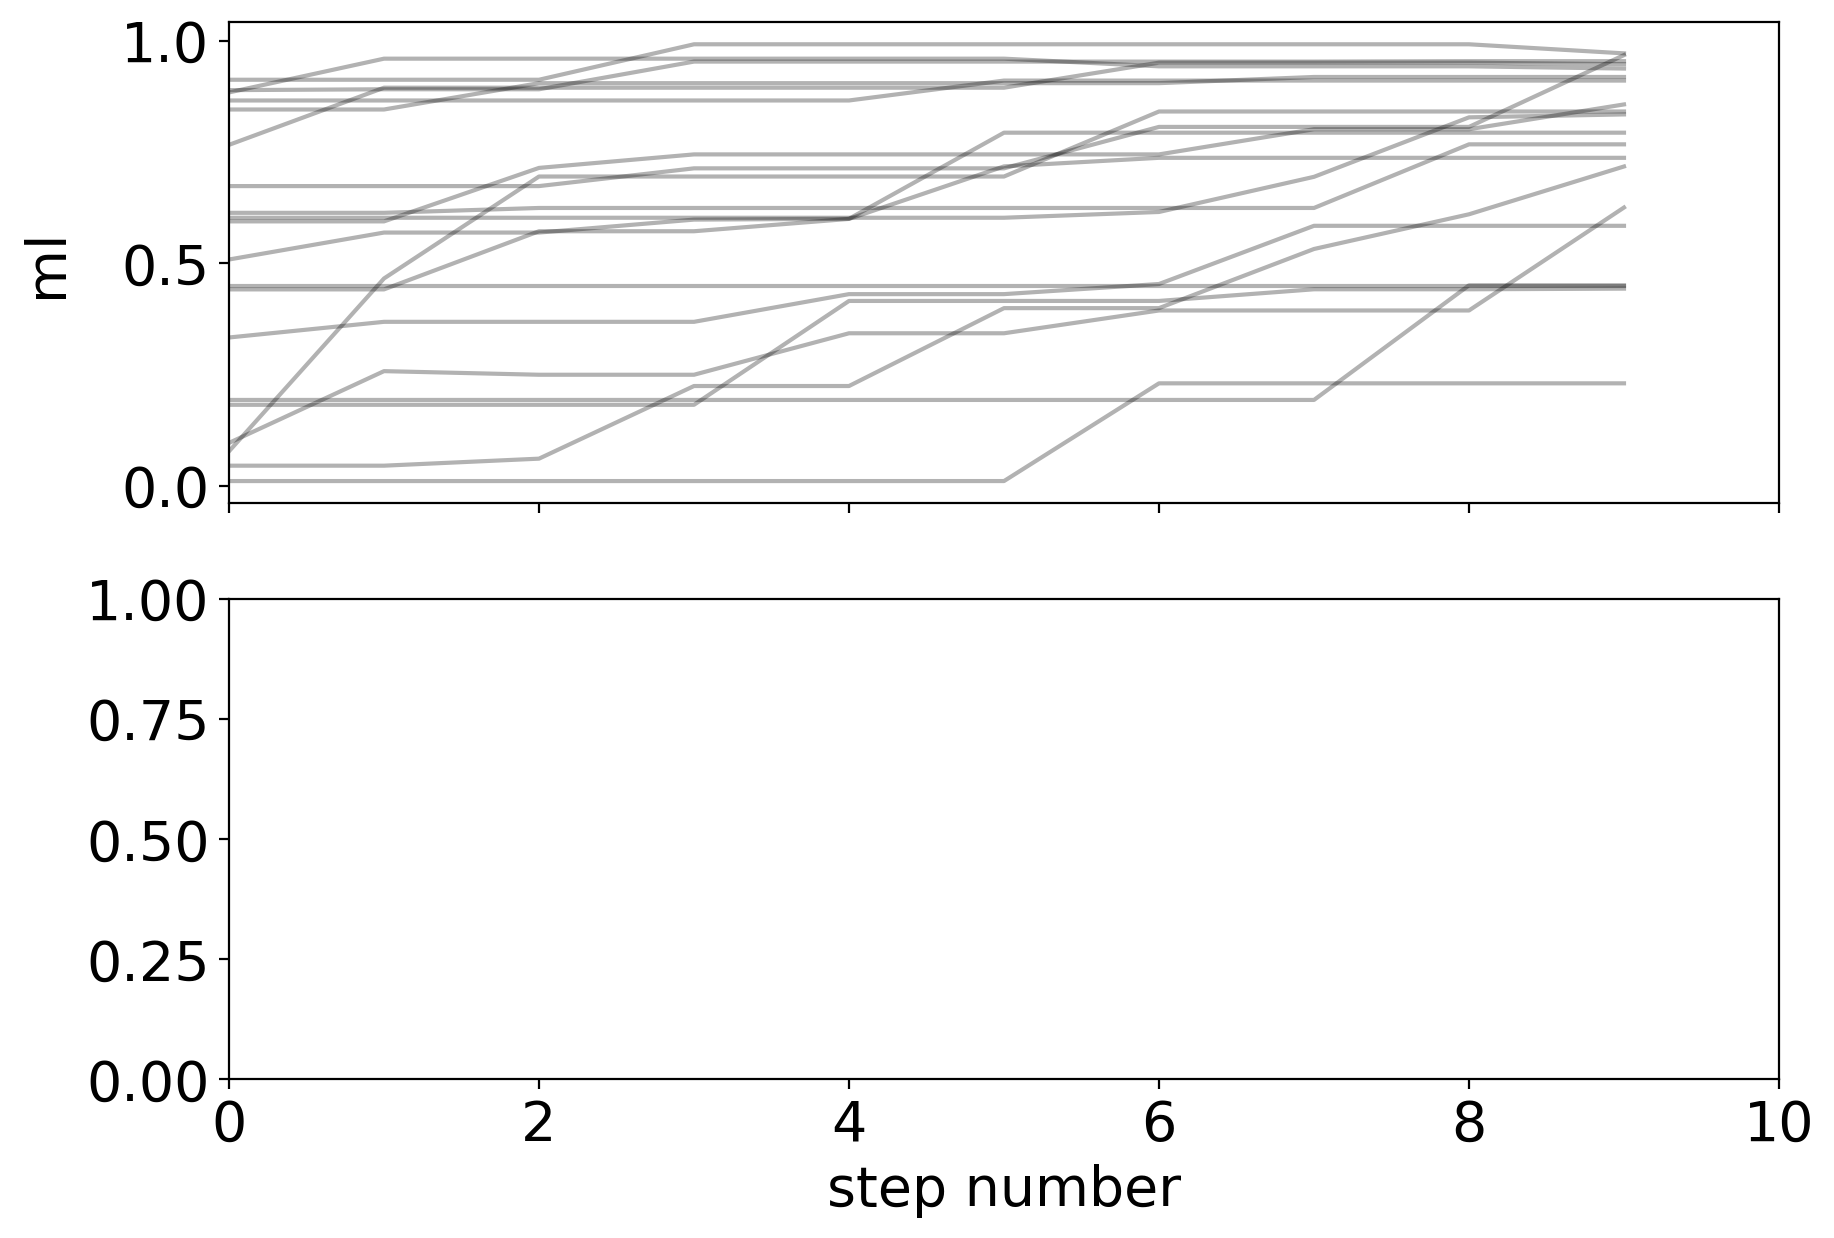

In [21]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["ml"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [22]:
flat_samples = sampler.get_chain(discard=1, thin=1, flat=True)
print(flat_samples.shape)

(180, 1)


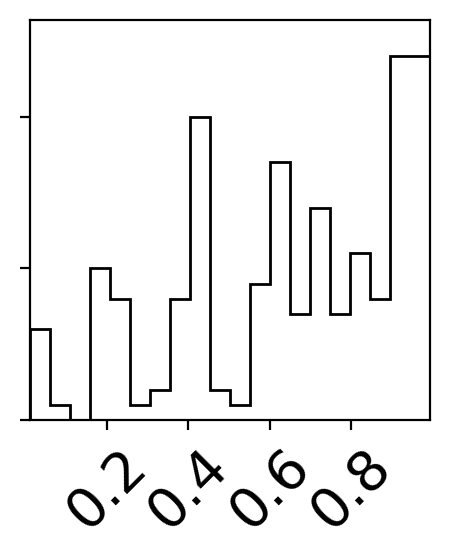

In [23]:
import corner

fig = corner.corner(
    flat_samples
);

In [24]:
from IPython.display import display, Math


mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(mcmc[1], q[0], q[1], labels[i])
display(Math(txt))

<IPython.core.display.Math object>